In [4]:
#获取测试数据
import requests
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/';
# #项目下的文件目录 datasets\housing
# #文件下载地址 https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.csv"

def download_data():
    csv_path = "./housing.csv"
    r = requests.get(HOUSING_URL)
    if r.status_code==200:
        print("写入数据成功")
        with open(csv_path,'wb') as f:
            f.write(r.content)
    else:
        print(f"访问最新数据失败statusCode={r.status_code}")
    r.close()
download_data()


写入数据成功


In [6]:
#加载数据
import pandas as pd
data=pd.read_csv("housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


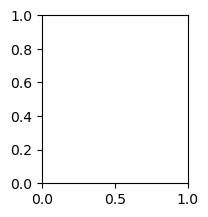

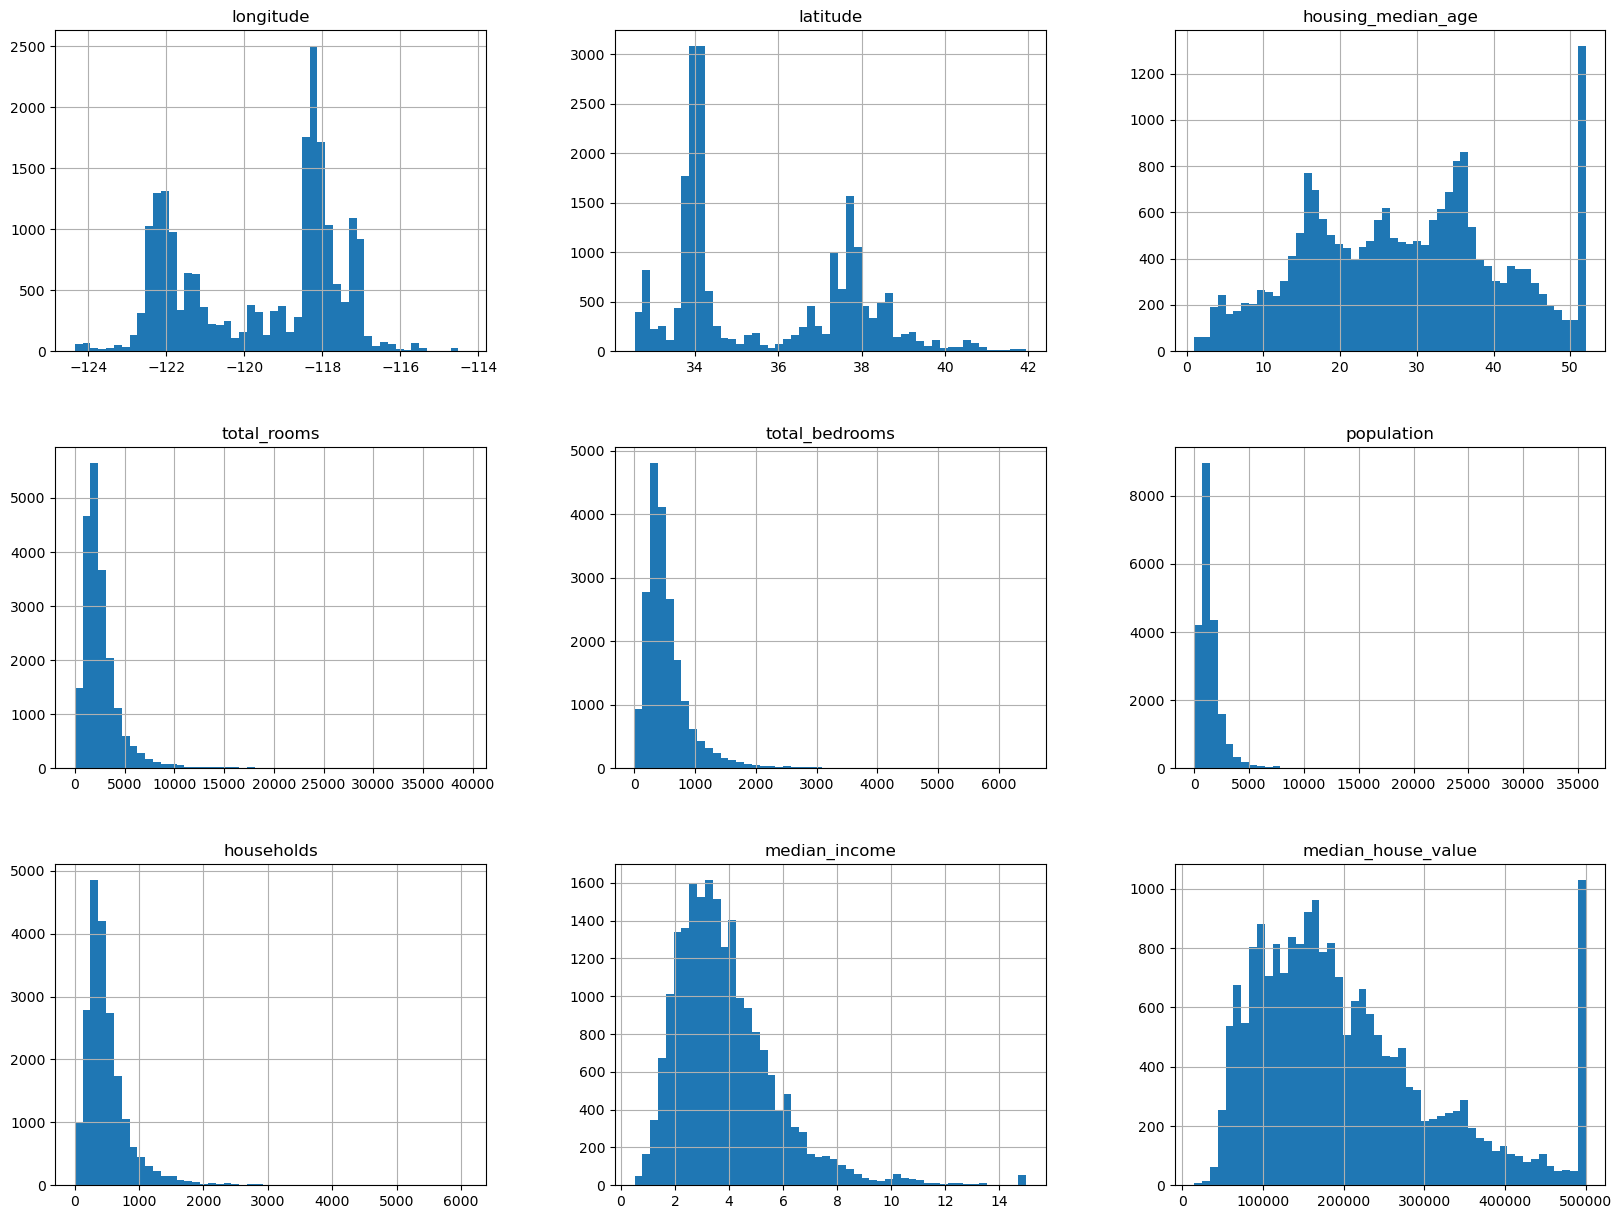

In [8]:
#可视化数据
%matplotlib inline
from matplotlib import pyplot as plt
# fig=plt.figure(figsize=(10.10))
fig1=plt.subplot(231)#现在新版本好像弃用了
# data.plot(kind='scatter', x='median_house_value',y='latitude',figsize = (10,10))##函数4：各属性各自的分布：即处于横轴区间（x轴）的样本个数为多少（y轴
# plt.scatter(data.loc[:,'median_house_value'],data.loc[:,'latitude'])
# plt.title('median_house_value vs latitude ')
data.hist(bins=50,figsize=(20,15))#展现各属性各自的分布
plt.show()

In [10]:
#查看文本类字段的值及其分布个数
data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

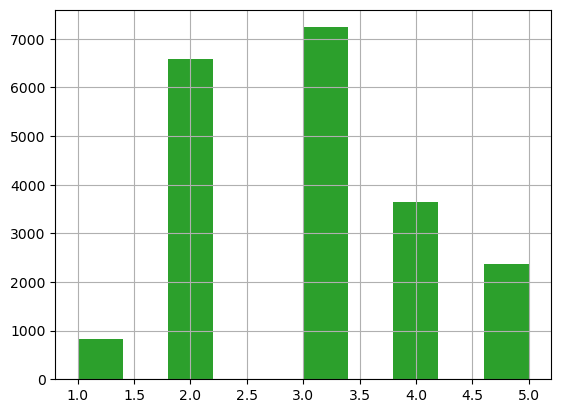

In [16]:
#接下来划分数据集，将其分为训练集和测试集，测试集的比例设置为20%
#房价和地区的收入是很有关系的，所以先把收入中位数分成几个类别category（cat）
import numpy as np
data['income_cat']=pd.cut(data['median_income'],bins=[0,1.5,3.,4.5,6.,np.inf],labels=[1,2,3,4,5])#这里创建五个收入分类标签1-5标签越大收入越大
data['income_cat'].hist()#生成收入直方图
plt.show()

In [18]:
#更具收入等级分层抽样，显示抽样比例分布
from sklearn.model_selection import StratifiedShuffleSplit
#sklearn.model_selection.train_test_split 为随记取样，其中，random_state=42是设置随机生成器种子
#sklearn.model_selection.StratifiedShuffleSplit 为分层取样
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]#训练集
    strat_test_set = data.loc[test_index]#测试集
#检验各个类别的比例分布
strat_test_set["income_cat"].value_counts()/len(strat_test_set)



income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [22]:
#现在分布拿到了那类别属性就不需要了
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

In [24]:
#创建数据副本，避免损坏测试集
housing=strat_train_set.copy()

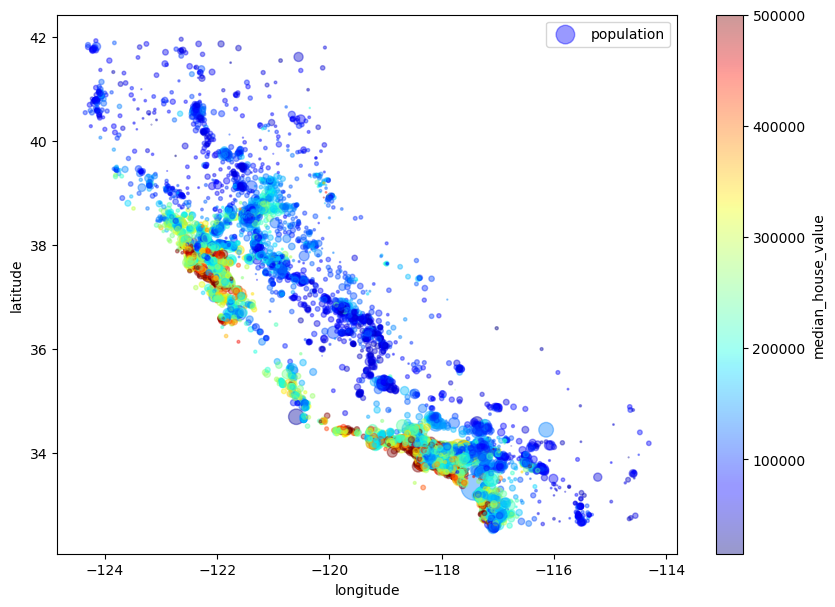

In [30]:
#查看房价和地理位置（x,y）以及人口密度s的关系
#横轴表示经度，纵轴表示维度，圆的半径大小表示了人口数量，颜色越红价格越高
#房价分布, s-蓝色-人口数量，c-颜色-价格-（蓝-红）
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, 
             s = housing["population"]/100, label = "population", figsize = (10,7), 
             c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True,
            )
plt.legend()
plt.show()

In [38]:
#选择出不是字符串的列
numeric_data = housing.select_dtypes(include=[np.number])
#计算每对属性的相关系数
corr_matrix=numeric_data.corr()
#每个属性与房价中位数的相关系数
corr_matrix['median_house_value'].sort_values(ascending=False)
#越靠1越相关

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

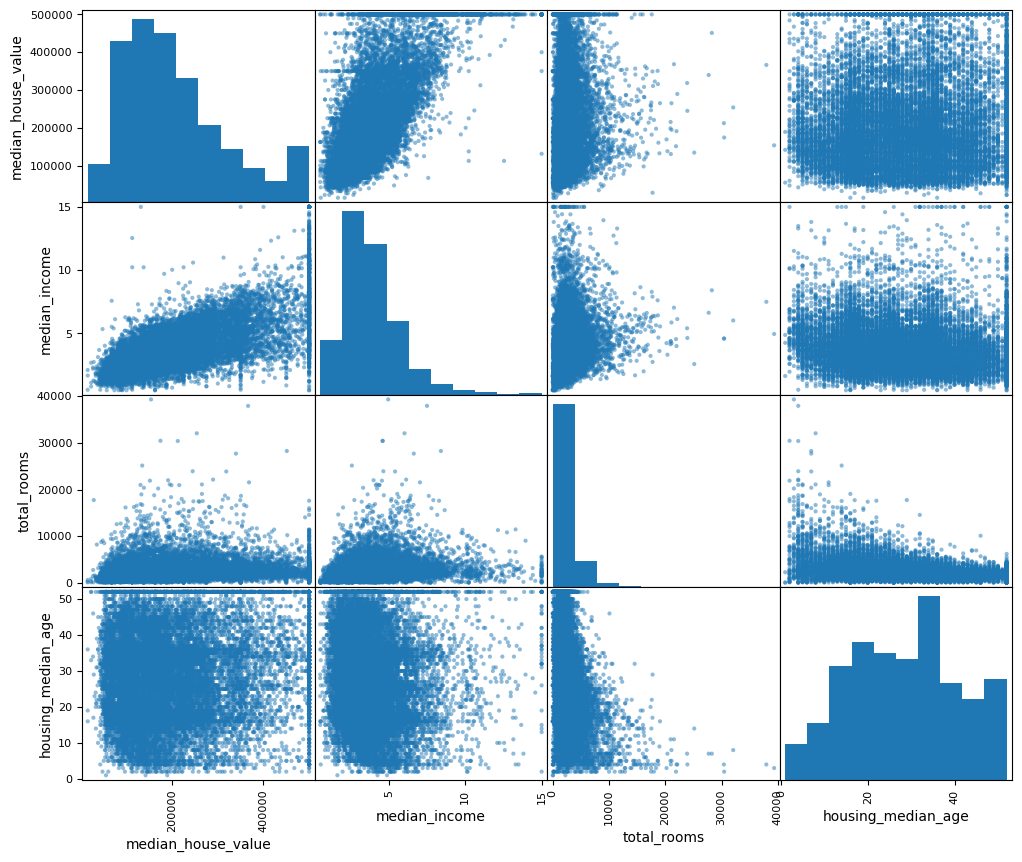

In [46]:
#看看各字段的相关性 两两对比应该是4*4=16个图
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,10))
plt.show()


In [50]:
#可以看到median_income确实和median_house_value有较明显的线性关系
#创建新的属性，来看看相关性
#几栋房/每家
#几个卧室/每栋房子
#几个人/每家
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]
corr_matrix = housing.select_dtypes(include=[np.number]).corr()
corr_matrix["median_house_value"].sort_values(ascending = False)



median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64